# Two-stage approach + R_convexity

- In this notebook, I implemented the two-stage approach and incorporated Tim's R_convexity to calculate the KLLN model.
- I modified the model so that, under the two-stage approach, liquidity-unconstrained agents make deposits.
- This results in changes to the money demand function and aggregate deposit sections.
- Specifically, liquidity-unconstrained buyers now receive a marginal benefit of i, and the total deposits increase by the amount of idle cash held by unconstrained buyers.
- The code was adjusted to account for R_convexity, with a focus on using Rfit within the R() function. Additionally, to calculate dJ (or dF), Rfit.derivative()(rho) is utilized.

Other critical areas to check include adjustments considering the measure of active and non-active buyers:
- Money demand function
- Equilibrium outcome
- Loan/deposit market clearing condition

Please review these aspects carefully.

Additionally, I still feel that the modifications to the money demand function across the z_range may not be fully complete. In particular, it’s uncertain whether i_bound, among other factors, should also be considered. I’ll finalize this part once Tim completes the Lemma arrangements.

## SME: BJ goods and competitive banks 
Given policy $\tau$, we get real money balance $(z)$ and market interest rate $(i=i_{l}=i_{d})$ by solving

\begin{equation}
\begin{split}
z^{\star} \leftarrow  \frac{1+\tau -\beta}{\beta} &= R(z,i)
\\
i_{l}=i_{d}=i^{\star} \leftarrow (1-n) \cdot z + n \cdot \int^{\overline{\rho}}_{\hat{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \delta(i,\rho,z)\text{d}J(\rho)&= n \cdot \int^{\tilde{\rho}}_{\underline{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \xi(i,\rho,z) \text{d}J(\rho)
\end{split}
\label{eq:k-phi-high-type-case1}
\end{equation}

where
\begin{equation*}
\begin{split}
R(z,i) &:=  \color{blue}{(1-n)} \cdot i + \color{blue}{n}\bigg[\int^{\tilde{\rho}}_{\underline{\rho}} i [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \text{d}J(\rho)
\\
&+ \int^{\hat{\rho}}_{\tilde{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \bigg[\frac{1}{\rho}\bigg(\frac{z}{\rho}\bigg)^{-\sigma} -1 \bigg] \text{d}J(\rho)
\\
&+ \int^{\overline{\rho}}_{\hat{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \cdot i \text{d}J(\rho)\bigg]
\end{split}
\end{equation*}

* Two equations and two unknowns 

In [1]:
import bcw_bj as main
import hlmw as hlmw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import interpolate
from scipy.optimize import brentq, fsolve
#import tikzplotlib
import time

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

In [3]:
font = {'family' : 'serif','weight':'normal',
        'size'   : 10}
plt.rc('font', **font)

In [4]:
σ_DM=0.3200
Ubar_CM=1.8000
n=0.65
α_1=0.0475
β=0.981
τ_min=β-1
τ_max = 0.05
τgrid_size = 60

In [5]:
model = main.baseline_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min)

model_hlmw =hlmw.hlmw_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min)

### SME: HLMW + perfectly competitive banks (Baseline)

* Vary $\tau \in [\beta-1, 0.1]$

In [6]:
z_guess = 0.7
i_guess = 0.01
result = model.SME_stat(z_guess, i_guess) # this uses fsolve

Elapsed time of solving SME: 99.96882796287537 seconds


In [7]:
z = result['allocation_grid']['zstar']
q = result['allocation_grid']['qstar']
ξ = result['allocation_grid']['ξstar']
i = result['allocation_grid']['istar']
DM_surplus = result['allocation_grid']['DM_surplus']
W = result['allocation_grid']['w_star']
W_BCW = result['allocation_grid']['w_bcw']

mpy = result['stat_grid']['mpy_star']
markup = result['stat_grid']['markup_mean']
markup_cv = result['stat_grid']['markup_cv']
loan_gdp = result['stat_grid']['credit_gdp']
loan_gdp_bcw = result['stat_grid']['credit_gdp_bcw']

### HLMW: without banks

In [8]:
result_hlmw = model_hlmw.SME_stat() # this uses brentq only

Elapsed time of solving SME: 75.03955459594727 seconds


In [9]:
z_hlmw = result_hlmw['allocation_grid']['zstar']
q_hlmw = result_hlmw['allocation_grid']['qstar']
W_hlmw = result_hlmw['allocation_grid']['w_star']
DM_surplus_hlmw = result_hlmw['allocation_grid']['DM_surplus']

mpy_hlmw = result_hlmw['stat_grid']['mpy_star']
markup_hlmw = result_hlmw['stat_grid']['markup_mean']
markup_cv_hlmw = result_hlmw['stat_grid']['markup_cv']

In [10]:
τ_grid = model.τ_grid # inflation rate grid
i_grid = model.i_policy(τ_grid)

In [11]:
font = {'family' : 'serif','weight':'normal',
        'size'   : 10}
plt.rc('font', **font)

### Difference welfare

* Comparision 1: $DW_{1}:= W_{Baseline} - W_{HLMW}$
    * Baseline economy: Price dispersion + perfectly competitive banks 
    * HLMW: Price dispersion
    * This shows the welfare gains/losses by isolating effects of **banking** only
    
    
* Comparision 2: $DW_{2}:= W_{BCW} -  W_{Baseline}$
    * Baseline economy: Price dispersion + perfectly competitive banks 
    * BCW: Competitive pricing + perfectly competitive banks
    * This shows the welfare gains/losses by isolating effects of **price dispersion** only
    
    
* Comparision 3: $DW_{3}:= W_{BCW} - W_{HLMW}$
    * HLMW: Price dispersion
    * BCW: Competitive pricing + perfectly competitive banks
    * This shows the welfare gains/losses by having both effects of **price dispersion** and **banking**

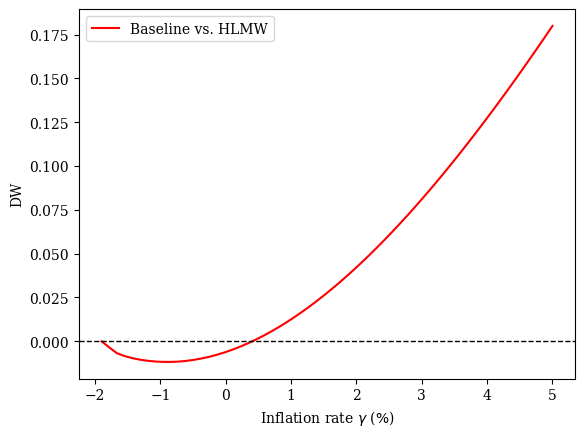

In [12]:
#plt.style.use(style='default')
W = result['allocation_grid']['w_star']
W_hlmw = result_hlmw['allocation_grid']['w_star']
DW = W - W_hlmw # Baseline vs. HLMW
DW_2 = W_BCW - W # BCW vs. Baseline
DW_3 = W_BCW - W_hlmw # BCW vs. HLMW
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid), DW, label='Baseline vs. HLMW',color='r')
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.ylabel("DW")
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
plt.savefig("DW.png")
plt.show()


#tikzplotlib.save("DW.tex")
#tikzplotlib.save("DW.pgf")

In [13]:
plt.rcParams['font.family'] = 'serif'

In [14]:
def gap_percent_func(delta_W_bank, W_no_bank):
    """Use this function to calculate CEV"""
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))
    gap_welfare = delta_W_bank - W_no_bank
    interp_fn = interpolate.interp1d(delta, gap_welfare, 'cubic')
    interp_fn2 = lambda x: interp_fn(x) - 0.0
    gap_delta = brentq(interp_fn2, delta.min(), delta.max())
    cev = (1.0 - gap_delta) * 100
    return cev

In [15]:
def calculate_cev_percent(τ, z_guess, i_guess, case='Case1'):
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))

    # klln
    z, i = model.solve_z_i(z_guess, i_guess, τ)

    # hlmw
    z_hlmw = model_hlmw.z_solver(τ)
    
    # Welfare increases by delta
    if case == 'Case1':
        delta_klln = [model.welfare_func_delta(z, i, τ, k) for k in delta]
            
    elif case == 'Case2':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]
            
    elif case == 'Case3':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]

    ### HLMW
    welfare_hlmw = model_hlmw.welfare_func(z_hlmw, τ)
    
    ### Baseline
    welfare_klln = model.welfare_func(z, i, τ)
    
    ### BCW
    welfare_bcw = model.welfare_bcw_func(τ)
    
    if case == 'Case1':
        cev_percent = gap_percent_func(delta_klln, welfare_hlmw)
        
    elif case == 'Case2':
        cev_percent = gap_percent_func(delta_bcw, welfare_klln)
        
    elif case == 'Case3':
        cev_percent = gap_percent_func(delta_bcw, welfare_hlmw)
  

    return cev_percent


In [16]:
Case1_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case1') for j in τ_grid ]

In [17]:
Case2_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case2') for j in τ_grid ]

In [18]:
Case3_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case3') for j in τ_grid ]

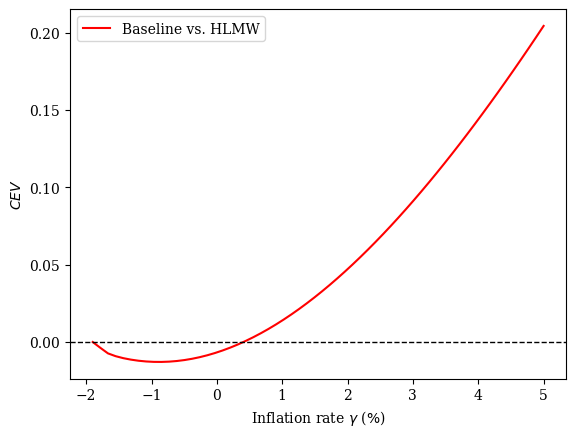

In [19]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid), Case1_cev, label='Baseline vs. HLMW',color='r')
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.ylabel("$CEV$")
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
plt.savefig("cev.png")
plt.show()

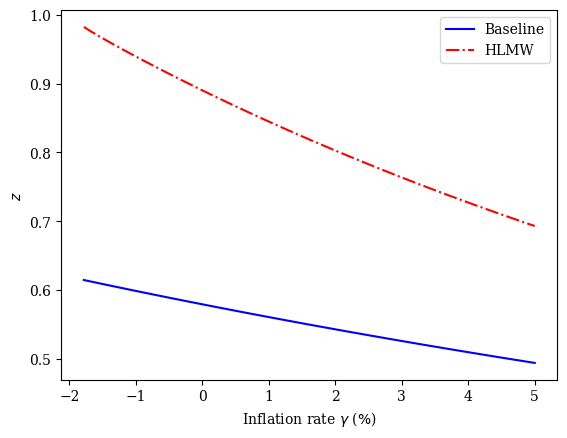

In [26]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), z[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), z_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$z$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
#plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("z.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

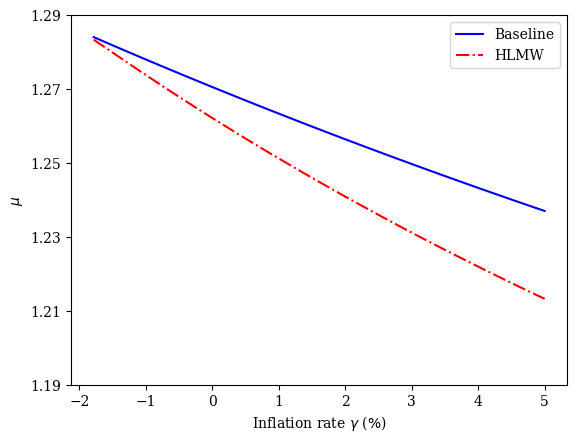

In [20]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), markup[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), markup_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$μ$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("markup.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


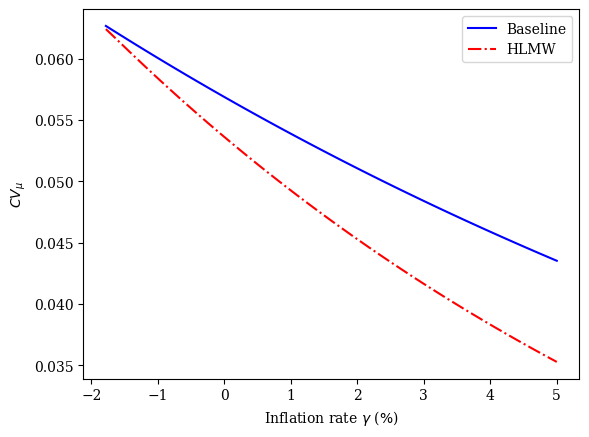

In [21]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), markup_cv[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), markup_cv_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$CV_{μ}$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
#plt.xlim(-0.5,8)
plt.savefig("markup_cv.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

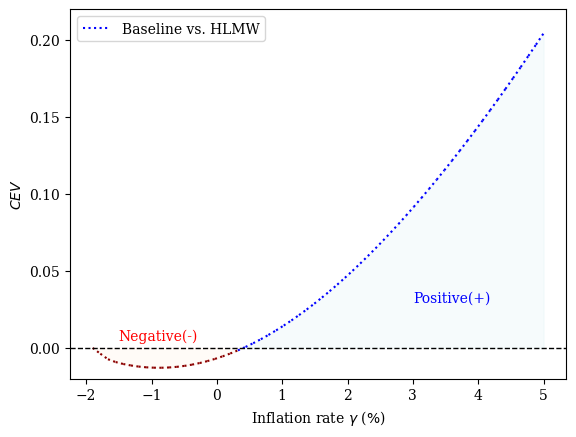

In [22]:
##### ZOOM-IN

##### plt.style.use(style='default')
plt.figure(facecolor='white')
# Initialize a flag to indicate when the label has been added
label_added_red = False
label_added_blue = False

for i in range(1, len(i_grid[0:60])):
    if Case1_cev[i-1] <= 0 and Case1_cev[i] > 0 or Case1_cev[i-1] > 0 and Case1_cev[i] > 0:
        # This segment is positive, plot in blue
        if not label_added_blue:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':', label='Baseline vs. HLMW')
            label_added_blue = True
        else:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':')
    else:
        # This segment is not positive, plot in dark red
        if not label_added_red:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')
            label_added_red = True
        else:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')


#plt.plot(i_grid[0:10]*100, np.zeros(τ_grid[0:30].size))
plt.ylabel("$CEV$")
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.fill_between(model.τ_grid[0:]*100, Case1_cev[0:], where=(np.array(Case1_cev)[0:] <= 0), color='peachpuff', alpha=0.1, interpolate=True)
plt.fill_between(model.τ_grid[0:]*100, Case1_cev[0:], where=(np.array(Case1_cev)[0:] >= 0), color='#B0E0E6', alpha=0.1, interpolate=True)
plt.text(-1.5, 0.005, 'Negative(-)',size=10,color='red')
plt.text(3, 0.03, 'Positive(+)',size=10,color='blue')
plt.ylim(-0.02,0.22)
plt.savefig("cev_zoom_in.png", bbox_inches='tight', pad_inches=0.05)
plt.show()